# 02 — European Call Pricing 

In this notebook, we prices European calls using Kou's model. We compute it using Laplace transform and its inversion. We compare this theoretical price with the Monte Carlo result and Black–Scholes.


## Laplace transform approach (Kou) and inversion to recover the call
Recall that under risk-neutral condition, the stock price under Kou's jump diffusion model is given by 
$$
S_t = S_0 \exp\Big\{ (r - \tfrac{1}{2}\sigma^2+\lambda \zeta) t + \sigma W_t \Big\} \prod_{i=1}^{N_t} V_i = S_0 \exp X_t
$$
The price of a European call with maturity $T$ and strike $K$ is given by
$$
C_T(k) = e^{-rT}\mathbb{E}[\max\{S_T - K,0 \}] = e^{-rT}\mathbb{E}[\max\{S_0e^{X_T}-e^{-k},0\}]
$$
where $k=-\ln K$. Suppose $\theta \in (-\eta_2,\eta_1)$. The moment generatin function of $X_t$ is given by
$$
E[e^{\theta X_t}] = \exp(G(\theta)t),
$$
where $G(\theta)$ is called the **cumulant exponent** of $\ln S_t-\ln S_0$, given by
$$
G(\theta)=\theta\!\left(r-\lambda\zeta-\tfrac12\sigma^2\right)  + \tfrac12\sigma^2\theta^2  + \lambda\!\left( p\frac{\eta_1}{\eta_1-\theta} + (1-p)\frac{\eta_2}{\eta_2+\theta} - 1 \right).
$$ Under Kou’s risk‑neutral dynamics,
Note: In the original paper of Kou (2002), Kou gives a closed form for the European call option price, using infinite series expressed in terms of the so-called Hh-function, which is hard to compute precisely, especially when the return variance $\sigma^2T$ and jump rate $\lambda$ are large. In a later survey paper, Kou proposed that one can use Laplace transform and its version to compute the call option price, which is still accurate and applicable to other derivative instruments, and useful in computing delta.

Kou shows that the **Laplace transform of the call $C_T(k)$ in $k$** (valid for $\Re(\xi)>0$) can be computed explicitly:

$$
\widehat{C}(\xi) = \int_{-\infty}^{\infty} e^{-\xi k} C_T(k) \mathrm{d}k
= e^{-rT}\frac{S_0^{\xi+1}}{\xi(\xi+1)}\exp\!\big(G(\xi+1)T\big),
$$


Hence to recover the price for a given $K$ (equivalently, $k=-\ln K$), invert the transform via the **Bromwich integral** (choose any $c>0$ inside the strip of analyticity, i.e. $0<c<\eta_1-1$):

$$
C_T(k) = \frac{1}{2\pi i}\int_{c-i\infty}^{c+i\infty} e^{\xi k}\widehat{C}(\xi)\mathrm{d}\xi
= \frac{e^{c k}}{\pi}\int_{0}^{\infty} \Re\!\big( e^{iuk}\widehat{C}(c+iu)\big)\mathrm{d}u.
$$

$G(\theta)$ is meromorphic with poles at $\theta=\eta_1$ and $\theta=-\eta_2$; selecting $c\in(0,\eta_1-1)$ keeps the integrand well‑defined.


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import norm

# For reproducibility
def rng(seed=None):
    return np.random.default_rng(seed)


In [3]:

def double_exponential_jump_sums(nums_jumps, p, eta1, eta2, rg):
    """
    return total jump sizes sum of Y_i's during a small time interval dt
    nums_jumps: array of numbers of jumps occuring during dt for different stock paths
    size of each jump Y_i is double exponential, namely +Exp(eta1) with probability p, 
    or -Exp(eta2) with probability 1-p.
    
    Vectorized implementation using a Binomial split and Gamma sums.

    total_Y = Sum_{j=1..nums_jumps} Y_j 
          = Gamma(nums_up_jumps, scale=1/eta1) /
            - Gamma(nums_down_jumps, scale=1/eta2).

    """
    nums_jumps = np.asarray(nums_jumps, dtype=np.int64)
    if nums_jumps.ndim == 0:
        nums_jumps = nums_jumps[None]
    
    # Divide all jumps into upward and downward jumps by binomial random draws
    nums_up_jumps = rg.binomial(nums_jumps, p)
    nums_down_jumps = nums_jumps - nums_up_jumps
    
    # Gamma(shape=nums_jumps, scale=1/eta). For k=0, we want 0, which means no jump. Handle zeros safely.
    total_Y_up = np.zeros_like(nums_jumps, dtype=float)
    up_jumps_indices = nums_up_jumps > 0 
    if up_jumps_indices.any():
        total_Y_up[up_jumps_indices] = rg.gamma(shape=nums_up_jumps[up_jumps_indices], scale=1.0/eta1)
    
    total_Y_down = np.zeros_like(nums_jumps, dtype=float)
    down_jumps_indices = nums_down_jumps > 0
    if down_jumps_indices.any():
        total_Y_down[down_jumps_indices] = rg.gamma(shape=nums_down_jumps[down_jumps_indices], scale=1.0/eta2)
    
    total_Y = total_Y_up - total_Y_down
    return total_Y.reshape(nums_jumps.shape)


In [4]:

def kou_paths(
    S0: float,
    T: float,
    n_steps: int,
    n_paths: int,
    sigma: float,
    lam: float,
    p: float,
    eta1: float,
    eta2: float,
    mu: float = None,
    r: float = None,
    seed: int = 42,
):
    """
    Simulate paths for Kou's double-exponential jump-diffusion.
    
    Args:
        S0: underlying stock price at time 0
        T: time to expiration in years
        n_steps: time steps
        n_paths: number of simulated paths
        sigma: yearly volatility
        lam: yearly jump intensity
        p: probability of up-jump (Y ~ +Exp(eta1)); q = 1 - p (down-jump Y ~ -Exp(eta2))
        eta1: rate of upward exponential; must satisfy eta1 > 1 for finite E[V]
        eta2: rate of downward exponential (> 0)
        mu: physical drift (use if r is None)
        r: risk-free interest rate; if provided, simulator uses risk-neutral drift (preferred for pricing)
        seed: RNG seed
    
    Returns:
        times (shape n_steps+1,), paths array (shape n_steps+1, n_paths)
    """
    assert S0 > 0 and T > 0 and n_steps >= 1 and n_paths >= 1
    assert sigma >= 0 and lam >= 0
    assert 0.0 <= p <= 1.0 and eta1 > 0 and eta2 > 0
    
    dt = T / n_steps
    rg = rng(seed)
    
    # Drift term in log S increment:
    if r is not None:
        # Risk-neutral drift uses zeta = E[e^Y]-1
        zeta = p * (eta1 / (eta1 - 1.0)) + (1.0 - p) * (eta2 / (eta2 + 1.0)) - 1.0
        mu_tilde = (r - 0.5 * sigma**2 - lam * zeta)
    else:
        if mu is None:
            raise ValueError("Provide either mu (physical) or r (risk-neutral).")
        mu_tilde = (mu - 0.5 * sigma**2)
    
    # Pre-allocate
    paths = np.empty((n_steps + 1, n_paths), dtype=float)
    paths[0, :] = S0
    sqrt_dt = np.sqrt(dt)
    
    # Draw Brownian increments and Poisson jump counts
    dW = rg.normal(loc=0.0, scale=sqrt_dt, size=(n_steps, n_paths))
    J = rg.poisson(lam=lam * dt, size=(n_steps, n_paths))
    
    # For each time step, compute jump-sum and log increment
    for t in range(n_steps):
        Y_sum = double_exponential_jump_sums(J[t], p=p, eta1=eta1, eta2=eta2, rg=rg)
        dX = mu_tilde * dt + sigma * dW[t] + Y_sum
        paths[t + 1] = paths[t] * np.exp(dX)
    
    times = np.linspace(0.0, T, n_steps + 1)
    return times, paths


## Pricing helpers (MC, BS, Laplace inversion)

In [ ]:
def bs_call(S0, K, sigma, T, r):
    '''
    Black-Scholes Call Option formula
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    T: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes value of call option (float)
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*T)/(sigma*np.sqrt(T))
    
    d2 = d1 - sigma*np.sqrt(T)
    
    
    call_value = S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    
    
    return call_value

def mc_price_kou_with_paths(n_paths, S0, K, T, r, sigma, lam, p, eta1, eta2,
                            steps=252, seed=None):
    '''
    Monte Carlo method to compute call option price

    Return Monte Carlo price and standard error
    '''

    times, S = kou_paths(S0, T, steps, n_paths, sigma, lam, p, eta1, eta2, r=r, seed=seed)
    ST = S[-1]
    payoff = np.maximum(ST - K, 0.0)
    disc_payoff = np.exp(-r*T)*payoff
    price = disc_payoff.mean()
    stderr = disc_payoff.std(ddof=1)/np.sqrt(n_paths)
    return price, stderr


In [9]:


def kou_cumulant(theta, r, sigma, lam, p, eta1, eta2):
    """
    Kou cumulant G(theta) for the log-return process X_T = ln S_T - ln S_0 under Q.

    Definition:
        G(theta) = theta * (r - lambda*zeta - 0.5*sigma^2) + 0.5*sigma^2 * theta^2
                   + lambda * ( p * eta1 / (eta1 - theta) + (1-p) * eta2 / (eta2 + theta) - 1 )

    where zeta = E[e^Y - 1] for Y ~ double-exponential jumps:
        zeta = p * eta1/(eta1 - 1) + (1-p) * eta2/(eta2 + 1) - 1

    Parameters
    ----------
    theta : float or complex or array-like
        Laplace variable. Valid for Re(theta) in (-eta2, eta1).
        Can be a numpy array of complex numbers (e.g., theta = c+1j*u + 1).
    r : float
        Risk-free rate (continuous compounding).
    sigma : float
        Diffusion volatility (>= 0).
    lam : float
        Jump intensity lambda (>= 0).
    p : float
        Probability of an upward jump (in (0,1)).
    eta1 : float
        Rate of upward exponential jump sizes (+Exp(eta1)); must satisfy eta1 > 1 for finiteness of E[e^Y].
    eta2 : float
        Rate of downward exponential jump sizes (-Exp(eta2)); must satisfy eta2 > 0.

    Returns
    -------
    G : complex ndarray or complex
        Same shape as theta. Complex-valued in general.
    """
    
    theta = np.asarray(theta, dtype=np.complex128)

    # Risk-neutral compensator for jumps
    zeta = p * (eta1 / (eta1 - 1.0)) + (1.0 - p) * (eta2 / (eta2 + 1.0)) - 1.0

    drift_term = theta * (r - lam * zeta - 0.5 * sigma**2)
    diff_term  = 0.5 * (sigma**2) * (theta**2)
    jump_term  = lam * ( p * (eta1 / (eta1 - theta)) + (1.0 - p) * (eta2 / (eta2 + theta)) - 1.0 )

    return drift_term + diff_term + jump_term


def kou_call_laplace_transform(xi, S0, T, r, sigma, lam, p, eta1, eta2):
    """
    Bilateral Laplace transform of the call price C_T(k) w.r.t. k = -ln K.

        Chat(xi) = ∫_{-∞}^{∞} e^{-xi k} C_T(k) dk
                 = e^{-rT} * S0^{xi+1} / [ xi (xi+1) ] * exp( G(xi+1) * T )

    where G is the Kou cumulant from `kou_cumulant`.

    Parameters
    ----------
    xi : float/complex or array-like
        Laplace variable for k. Must satisfy Re(xi) > 0 and Re(xi+1) in (-eta2, eta1).
    S0 : float
        Spot price (S0 > 0).
    T : float
        Time to maturity in years (T >= 0).
    r, sigma, lam, p, eta1, eta2 : floats
        Kou model parameters under the risk-neutral measure.

    Returns
    -------
    Chat : complex ndarray or complex
        Transform values at xi; same shape as xi.
    """

    xi = np.asarray(xi, dtype=np.complex128)
    theta = xi+1
    G = kou_cumulant(theta, r, sigma, lam, p, eta1, eta2)
    # compute S0^(xi+1) robustly for complex xi
    return np.exp(-r*T) * (S0**(xi+1)) * np.exp(G*T) / (xi * (xi + 1))


def kou_call_laplace_price(S0, K, T, r, sigma, lam, p, eta1, eta2,
                           c=None, u_max=200.0, N=20000):
    if c is None:
        c = 0.5 * min(eta1 - 1.0, 1.0)
        c = max(c, 1e-3)
    k = -np.log(K)
    u = np.linspace(1e-6, u_max, N)
    xi = c + 1j*u
    Chat = kou_call_laplace_transform(xi, S0, T, r, sigma, lam, p, eta1, eta2)
    integrand = np.real(np.exp(1j*u*k) * Chat)
    du = (u_max - u[0]) / (N - 1)
    val = np.exp(c*k)/np.pi * np.trapezoid(integrand, dx=du)
    return float(max(val, 0.0))


## Experiments
### 1) MC convergence under Kou 

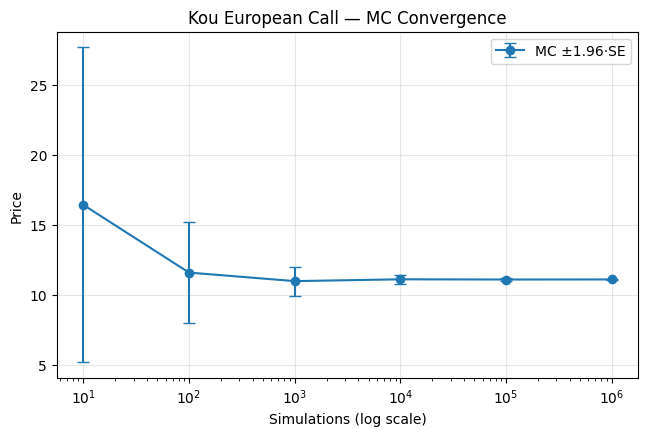

Monte-Carlo price (Kou_path): Number of similations=10  ->  Call estimated=16.422417  (Standard Error=5.739613)
Monte-Carlo price (Kou_path): Number of similations=100  ->  Call estimated=11.586184  (Standard Error=1.847523)
Monte-Carlo price (Kou_path): Number of similations=1,000  ->  Call estimated=10.976533  (Standard Error=0.528197)
Monte-Carlo price (Kou_path): Number of similations=10,000  ->  Call estimated=11.105683  (Standard Error=0.170484)
Monte-Carlo price (Kou_path): Number of similations=100,000  ->  Call estimated=11.090097  (Standard Error=0.053855)
Monte-Carlo price (Kou_path): Number of similations=1,000,000  ->  Call estimated=11.095280  (Standard Error=0.017027)
Price under Kou-Laplace transform: 11.067143
Price under Black-Scholes: 9.413403


In [38]:

S0, K, T = 100.0, 100.0, 1.0
r, sigma = 0.03, 0.20
lam, p, eta1, eta2 = 3.0, 0.6, 25.0, 12.5
steps = 252

Ns = [10, 100, 1000, 10000, 100000, 1000000]
mc_prices, mc_stderrs = [], []
for n in Ns:
    price, se = mc_price_kou_with_paths(n, S0, K, T, r, sigma, lam, p, eta1, eta2,
                                        steps=steps, seed=20221)
    mc_prices.append(price); mc_stderrs.append(se)

plt.figure(figsize=(7.5,4.5))
plt.errorbar(Ns, mc_prices, yerr=[1.96*s for s in mc_stderrs], fmt='o-', capsize=4, label='MC ±1.96·SE')
plt.xscale('log')
plt.xlabel('Simulations (log scale)'); plt.ylabel('Price')
plt.title('Kou European Call — MC Convergence')
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

for n, pr, se in zip(Ns, mc_prices, mc_stderrs):
    print(f"Monte-Carlo price (Kou_path): Number of similations={n:,}  ->  Call estimated={pr:.6f}  (Standard Error={se:.6f})")

kou_price = kou_call_laplace_price(S0, K, T, r, sigma, lam, p, eta1, eta2)
bs_price = bs_call(S0, K, sigma, T, r)

print(f"Price under Kou-Laplace transform: {kou_price:.6f}")
print(f"Price under Black-Scholes: {bs_price:.6f}")

### 2) Laplace-inversion price (Kou) and Black–Scholes; compare to MC

In [39]:

kou_lap_price = kou_call_laplace_price(S0, K, T, r, sigma, lam, p, eta1, eta2)
bs_price     = bs_call(S0, K, T, r, sigma)
print(f"Kou (Laplace) price : {kou_lap_price:.6f}")
print(f"BS price            : {bs_price:.6f}")
print(f"MC (best) price     : {mc_prices[-1]:.6f}  ± {1.96*mc_stderrs[-1]:.6f} (95% Confidence Interval)")


Kou (Laplace) price : 11.067143
BS price            : 7.183833
MC (best) price     : 11.095280  ± 0.033373 (95% Confidence Interval)


### 3) Plot Price vs Strike under Kou (Laplace) and Black–Scholes

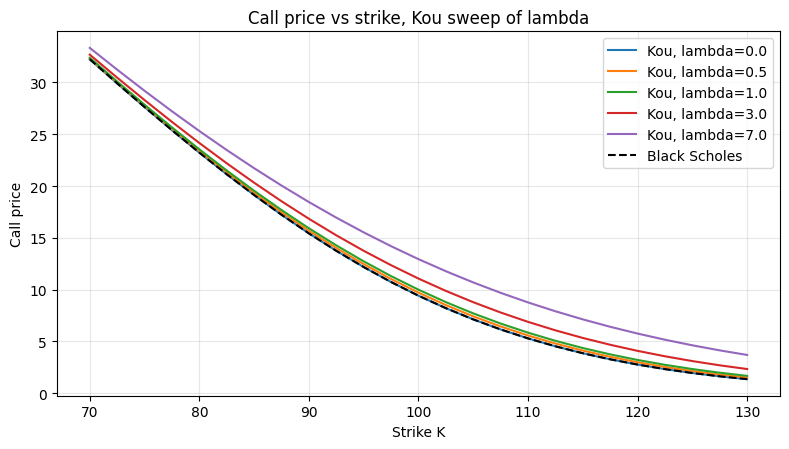

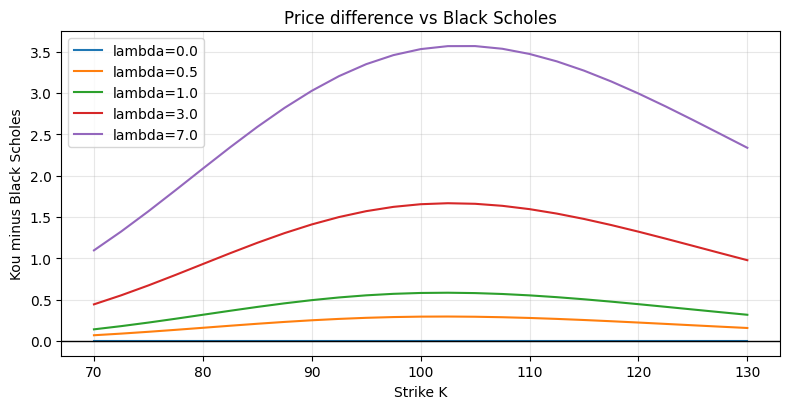

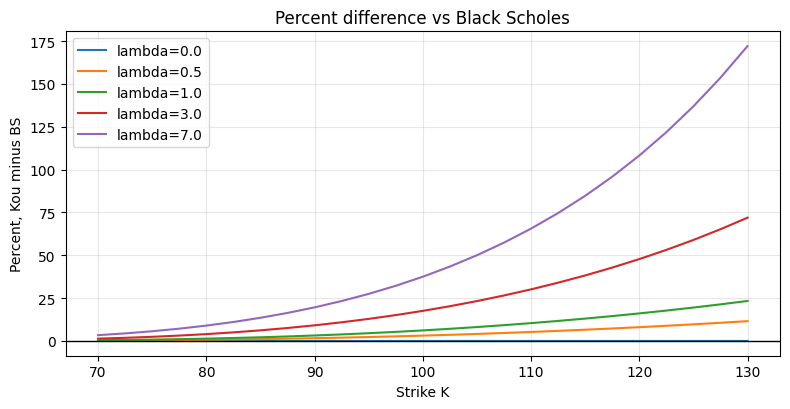

In [48]:
# strike grid
strikes = np.linspace(70, 130, 25)

# choose lambda values to compare
lam_list = [0.0, 0.5, 1.0, 3.0, 7.0]

# Kou prices for each lambda
kou_by_lam = {
    lam: np.array([kou_call_laplace_price(S0, k, T, r, sigma, lam, p, eta1, eta2)
                   for k in strikes])
    for lam in lam_list
}

# Black Scholes baseline
bs_grid = np.array([bs_call(S0, k, T, r, sigma) for k in strikes])

# 1) Call price vs strike
plt.figure(figsize=(8, 4.6))
for lam, grid in kou_by_lam.items():
    plt.plot(strikes, grid, label=f'Kou, lambda={lam}')
plt.plot(strikes, bs_grid, '--', color='k', label='Black Scholes')
plt.xlabel('Strike K'); plt.ylabel('Call price')
plt.title('Call price vs strike, Kou sweep of lambda')
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# 2) Difference vs Black Scholes
plt.figure(figsize=(8, 4.2))
for lam, grid in kou_by_lam.items():
    plt.plot(strikes, grid - bs_grid, label=f'lambda={lam}')
plt.axhline(0, lw=1, color='k')
plt.xlabel('Strike K'); plt.ylabel('Kou minus Black Scholes')
plt.title('Price difference vs Black Scholes')
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# 3) Percent difference vs Black Scholes
eps = 1e-12
plt.figure(figsize=(8, 4.2))
for lam, grid in kou_by_lam.items():
    pct = 100.0 * (grid - bs_grid) / np.maximum(bs_grid, eps)
    plt.plot(strikes, pct, label=f'lambda={lam}')
plt.axhline(0, lw=1, color='k')
plt.xlabel('Strike K'); plt.ylabel('Percent, Kou minus BS')
plt.title('Percent difference vs Black Scholes')
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()
